In [2]:
import sys
sys.path.append("..")
import gene_transcript_go_api as gtga
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
from random import sample
from statistics import mean, stdev
import scipy as sp
import scipy.optimize
import numpy as np

In [5]:
human = gtga.parse_pannzer_annotation('/home/pgerenton/Documents/multiisoformVSsingleisoform/data/pannzer_output/human.nr_off.pc.out', 'human_gencode')

In [74]:
def nGO(gene : gtga.Gene) -> int:
    return len(gene.get_go_term_id())

def plot_nGO(gene : gtga.Gene) -> None:
    n_max : int = gene.number_of_isoforms()
    nGOs : list[int] = []
    ni : list[int] = []
    for i in range(0, n_max+1):
        transcript_list : list[gtga.Transcript] = list(gene.transcripts.values())
        iterresult : list[int]= []
        for _ in range(500):
            sub_transcript_list : list[gtga.Transcript] = sample(transcript_list, i)
            tmp_gene : gtga.Gene = gtga.Gene('unk','unk')
            tmp_gene.add_transcripts(sub_transcript_list)
            iterresult.append(nGO(tmp_gene))
        nGOs.append(mean(iterresult))
        ni.append(i)
    sns.pointplot(x=ni, y=nGOs)
    pyplot.xlabel('Number of isoforms')
    pyplot.ylabel('Number of GO terms')
    pyplot.title('Number of GO terms as a function of the number of isoforms')

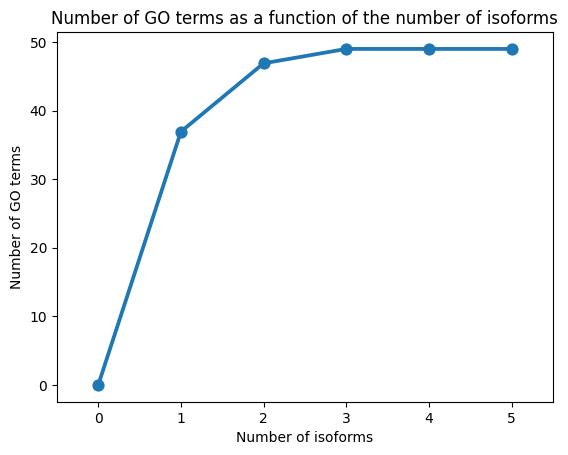

In [170]:
test_gene = [human[gene] for gene in human if human[gene].number_of_isoforms() >=3][66] # 953 et 85
plot_nGO(test_gene)

In [202]:
def logistic(x, K, r, m):
    a = ( K  /  ( K - m) ) - 1
    offset =  - (K / (1 + a))
    return (K)/(1+ a*np.exp(-r*x)) + offset

def logistic_offset(K, r, m):
    a = ( K  /  ( K - m) ) - 1
    offset = - (K / (1 + a))
    return offset

def asymptote(param):
    return param[2]

In [249]:
def plot_fit_nGO(gene : gtga.Gene) -> None:
    n_max : int = gene.number_of_isoforms()
    nGOs : list[int] = []
    ni : list[int] = []
    for i in range(0, n_max+1):
        transcript_list : list[gtga.Transcript] = list(gene.transcripts.values())
        iterresult : list[int]= []
        for _ in range(5000):
            sub_transcript_list : list[gtga.Transcript] = sample(transcript_list, i)
            tmp_gene : gtga.Gene = gtga.Gene('unk','unk')
            tmp_gene.add_transcripts(sub_transcript_list)
            iterresult.append(nGO(tmp_gene))
        nGOs.append(mean(iterresult))
        ni.append(i)
    sns.pointplot(x=ni, y=nGOs)
    pyplot.xlabel('Number of isoforms')
    pyplot.ylabel('Number of GO terms')
    pyplot.title('Number of GO terms as a function of the number of isoforms')

    opt_coef, pcov = scipy.optimize.curve_fit(logistic, ni, nGOs,p0=[2*np.max(nGOs), 0.5, np.max(nGOs)], bounds=([np.max(nGOs),0,np.max(nGOs)],[np.inf, np.inf, np.inf]),maxfev = 50000)
    curve_x = np.arange(0,gene.number_of_isoforms()+5, 0.2)
    curve_y = logistic(np.array(curve_x), *opt_coef)
    pyplot.axhline(asymptote(opt_coef), color = 'red')
    pyplot.plot(curve_x, curve_y, 'b-', color = "green")
    
    residuals = np.array(nGOs) - logistic(np.array(ni), *opt_coef)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((nGOs - np.mean(nGOs))**2)
    return 1 - (ss_res / ss_tot), opt_coef

/tmp/ipykernel_224650/353067567.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  pyplot.plot(curve_x, curve_y, 'b-', color = "green")


(0.9997985762550687, array([3.05204041e+04, 2.04865745e-02, 8.84850934e+02]))

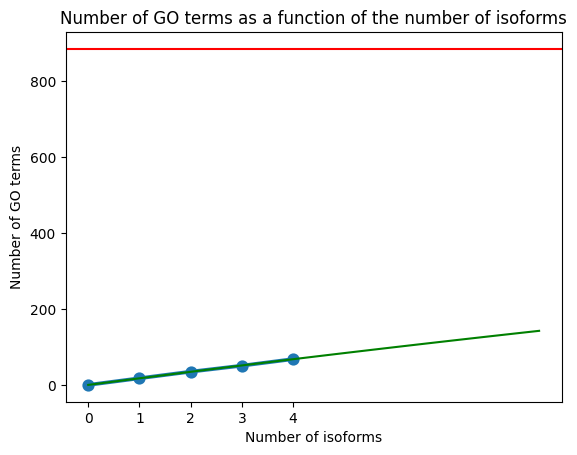

In [266]:
test_gene = [human[gene] for gene in human if human[gene].number_of_isoforms() >= 3][85] # 953 et 85 et 45

plot_fit_nGO(test_gene)